# Adaptive MPC with Real-Time Model Updating

created on March 1st, 2025

In [16]:
# Import all the packages we need
import numpy as np
import pandas as pd
from typing import Optional, Tuple

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import pickle
from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time
from torch.nn import ReLU

# from pytorch_forecasting.metrics.quantile import QuantileLoss

# For LSTM
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

from sklearn.preprocessing import StandardScaler
import torch.autograd.functional as F

# For TFT
from tqdm import tqdm_notebook as tqdm

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)


# import functions
from TiDE import TideModule, TiDE_forward
from sys_model import nominal_model, nominal_model_recur, system_model
from RobustMPC_pytorch import RMPC_pytorch_iteration
from utils import sigmoid, LossParameters, GlobalState


cuda is available


## Load nominal model

In [17]:
# Open the pickle file
with open('nominal_params_w10_mid_noise_stable_final.pkl', 'rb') as file:
    # 2. Load the data from the pickle file
    nominal_params = pickle.load(file)
# Load nominal TiDE model
nominal_TiDE = nominal_params['model'].to("cpu")
nominal_TiDE.load_state_dict(torch.load('nominal_params_w10_mid_noise_stable_final.pth'))
nominal_TiDE.eval()
window = 10

## Load tube model

In [18]:
# Open the pickle file
with open('controlled_quantile_params_w10_mid_noise_with_x.pkl', 'rb') as file:
    # 2. Load the data from the pickle file
    tube_params = pickle.load(file)
# Load nominal TiDE model
tube_TiDE = tube_params['model'].to("cpu")
tube_TiDE.load_state_dict(torch.load('controlled_quantile_TiDE_w10_mid_noise_with_x_smaller_k_5_quantile.pth'))
tube_TiDE = tube_TiDE.eval()
P = 10

## Load reference trajectory

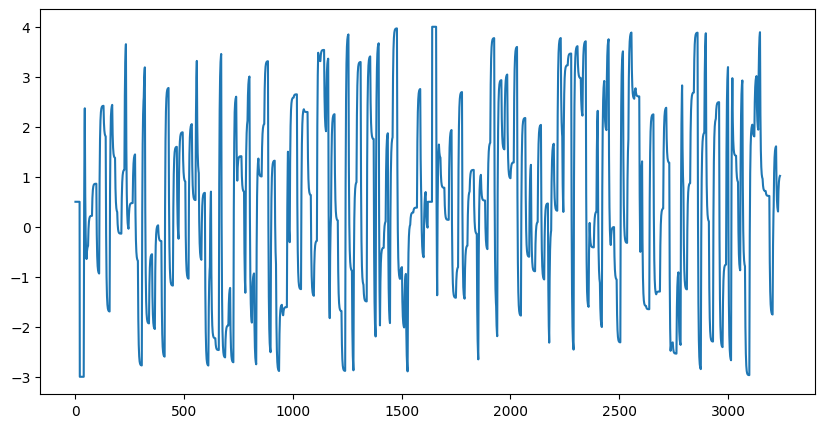

In [19]:
path = ''
data = pd.read_pickle(path + 'open_loop_data_SISO.pkl')

data["y"][1:] = data["y"][0:-1]
Ref_traj = data["y"].values*3.5 - 3.5
Ref_traj = torch.tensor(np.concatenate((np.zeros((20)),Ref_traj)),dtype=torch.float32)
Ref_traj = torch.concat((Ref_traj,Ref_traj*-1)) +0.5

plt.figure(figsize=(10, 5))
plt.plot(Ref_traj)


## Objective function with constrain penalty

In [20]:
# Utils

LossParam = LossParameters(alpha0=1, delta_alpha = 3, lamda0 = 10)
relu = ReLU()
global_state = GlobalState()


def RMPC_obj_TiDE_pytorch_w_x(u_hat:torch.tensor, # future u values within the control horizon, length = M; this should be the warm start version
                u_past:torch.tensor, # past u
                x_past: torch.tensor, # past state of x, size (N,window)
                SP_hat:torch.tensor, # Reference trajectory, length = P
                P, # Predictive Horizon
                NN_Nominal, # Nominal TiDE model that we're using
                tube_model = None,
                error_history = None,
                x_max=None,
                x_min=None,
                u_max=None,
                u_min=None,
                constraint_evaluation = True
):
    
    # convert u_hat into tensor and set u_hat as variable
    u_hat_in = u_hat.unsqueeze(0)
    
    # knit past and future covariate into the input format for TiDE
    past_cov = torch.tensor(np.concatenate((x_past,u_past), axis = 0),dtype=torch.float32).transpose(1,0).unsqueeze(0)
    # TiDE prediction
    x_hat_s_all = NN_Nominal([past_cov,u_hat_in,None]) # normalized value
    
    # compute objective value
    x_hat_s = x_hat_s_all[0,:,0,1]
    u_hat_temp = u_hat_in[0,:,0].reshape(-1,1) 

    u = u_hat_temp[0].reshape(-1,1)
    u_hat0 = torch.concatenate((u,u_hat_temp)) # append the computed u with the history u
    
    Obj = 1 * torch.sum((x_hat_s-torch.tensor(SP_hat,dtype=torch.float32))**2) + 1*torch.sum((u_hat0[1:]-u_hat0[0:-1])**2) 
            #+ 10*(x_hat_s[-1]-torch.tensor(SP_hat[0,-1]))**2


    if constraint_evaluation == False:
        return Obj
    else:
        return Obj, x_hat_s_all
    


def x_constraint_check_w_x(u_hat, u_past_s, tube_model, tube_params, error_history, x_past_s, x_hat_s, x_max, x_min, u_max, u_min, NN_nominal):
    
    # ======= Median Prediction   =========
    # convert x_hat_s into original scale
    x_hat_s_med = x_hat_s[0,:,:,1]
    x_hat = ((x_hat_s_med + 1).reshape(-1,2) * 0.5 * ((x_max-x_min).reshape(-1,2)) + x_min.reshape(-1,2))[:,:] # shape:[P,2]
    
    # ======== x nominal quantile =========
    x_lower_quantile = ((x_hat_s[0,:,:,0] + 1).reshape(-1,2) * 0.5 * ((x_max-x_min).reshape(-1,2)) + x_min.reshape(-1,2))
    x_upper_quantile = ((x_hat_s[0,:,:,2] + 1).reshape(-1,2) * 0.5 * ((x_max-x_min).reshape(-1,2)) + x_min.reshape(-1,2))
    
    # ======= Past x ====================
    # convert x_past_s into original scale
    x_past = ((x_past_s + 1).reshape(2,-1) * 0.5 * ((x_max-x_min).reshape(2,-1)) + x_min.reshape(2,-1)).transpose(1,0) # shape: [P,2]

    
    # ======= Tube Prediction ===========    
    # use the u, x and e in original scale to predict tube quantile
    
    # convert u_scaled into original scale
    u_max = torch.tensor(u_max)
    u_min = torch.tensor(u_min)
    u_original_scale = (u_hat + 1).reshape(-1,1)*0.5*(u_max-u_min).reshape(-1,1) + u_min.reshape(-1,1) # shape: [P,2]
    
    # convert u_past_s to original scale
    u_past = (u_past_s + 1).reshape(-1,1)*0.5*(u_max-u_min).reshape(-1,1) + u_min.reshape(-1,1)        # shape: [window,1]

    # load error history (it should be saved in original scale already)
    if torch.all(error_history) == 0:
        error_history = error_history.transpose(1,0) # shape = [10,2]
    else:
        error_history = error_history.transpose(1,0).reshape(-1,2) # shape = [10,2]
    
    # predict future error        
    past_cov_error = torch.concatenate((error_history,x_past,u_past), axis = 1).unsqueeze(0) # shape = [1,P,3]
    future_cov = torch.concatenate((x_hat,u_original_scale),axis = 1).unsqueeze(0)
    error_hat = tube_model([past_cov_error,future_cov,None])[0,:,:,:] # scaled pred median of x1 and x2, shape = [10,2,3]

    # add median and ub/lb of tube
    # get upper and lower bound of x1 and x2 prediction
    
    # without tube
    # x1_upper = x_hat[:,0] 
    # x1_lower = x_hat[:,0] 
    # x2_upper = x_hat[:,1] 
    # x2_lower = x_hat[:,1]
    
    # aleatoric uncertainty from nominal quantile only
    x1_upper = x_upper_quantile[:,0] 
    x1_lower = x_lower_quantile[:,0]
    x2_upper = x_upper_quantile[:,1]
    x2_lower = x_lower_quantile[:,1]  
    
    # aleatoric uncertainty from error quantile only
    # x1_upper = x_hat[:,0] + error_hat[:,0,2] 
    # x1_lower = x_hat[:,0] + error_hat[:,0,0] 
    # x2_upper = x_hat[:,1] + error_hat[:,1,2] 
    # x2_lower = x_hat[:,1] + error_hat[:,1,0] 
    
    # add aleatoric uncertainty from error quantile and nominal quantile
    # x1_upper = error_hat[:,0,2] + x_upper_quantile[:,0] 
    # x1_lower = error_hat[:,0,0] + x_lower_quantile[:,0]
    # x2_upper = error_hat[:,1,2] + x_upper_quantile[:,1]
    # x2_lower = error_hat[:,1,0] + x_lower_quantile[:,1]   
    
        
    x1_upper = torch.max(x1_upper)
    x1_lower = torch.min(x1_lower)
    x2_upper = torch.max(x2_upper)
    x2_lower = torch.min(x2_lower)
    
    

    # Here is where we can assign the upper and lower bound for the response
    g1 = (x1_upper - 2.5)/2.5
    g2 = (-2 - x1_lower)/2
    g3 = (x2_upper - 3.5)/3.5
    g4 = (-3.5 - x2_lower)/3.5

    return g1, g2, g3, g4
        

def penalty_obj_w_x(u_hat:torch.tensor, # original scale, future u values within the control horizon, length = M; this should be the warm start version
                u_past: torch.tensor, # past u in original scale 
                u_past_s:torch.tensor, # scaled, past u
                x_past_s: torch.tensor, # past state of x, size (N,window)
                SP_hat_s:torch.tensor, # Reference trajectory, length = P
                P, # Predictive Horizon
                NN_Nominal, # Nominal TiDE model that we're using
                u_lb: torch.tensor, # scaled, the lower bound of the design space, should be given by the u_tightening
                u_ub: torch.tensor, # scaled, the upper bound of the design space, should be given by the u_tightening
                obj, # The MPC objective function
                g, # The constraint bound check
                optim_iter_count, # Number of optimization iteration
                LossParam, # LossParam class that includes parameters for augmented Lagrangian. 
                tube_model = None, # Tube model, if given
                tube_params = None,
                error_history = None, # scaled? 
                x_max=None,
                x_min=None,
                u_max=None,
                u_min=None,
                constraint_evaluation = False
                ):
 
    
    u_hat_sig = sigmoid(u_hat,u_ub,u_lb).reshape(-1,1)
    u_hat_s = u_hat_sig
    
    # Evaluate objective value
    obj, x_hat_s = obj(u_hat_s, u_past_s, x_past_s, SP_hat_s, P, NN_Nominal)
    
    # Normalize objective value
    if global_state.optim_iter_count == 0 or global_state.optim_iter_count == 10:
        global_state.update_f0(obj.item())
    
    obj_s = obj/global_state.get_f0()  

    if constraint_evaluation == True:
    # # Evaluate constraint value
        g1, g2, g3, g4 = g(u_hat_s, u_past_s, tube_model, tube_params, error_history, x_past_s, x_hat_s, x_max, x_min, u_max, u_min, NN_Nominal)

        # combined loss
        Loss_g1 = LossParam.lamda_0.item()*relu(g1) + 0.5*LossParam.alpha_0.item()*(relu(g1)**2)
        Loss_g2 = LossParam.lamda_1.item()*relu(g2) + 0.5*LossParam.alpha_1.item()*(relu(g2)**2)
        Loss_g3 = LossParam.lamda_2.item()*relu(g3) + 0.5*LossParam.alpha_2.item()*(relu(g3)**2)
        Loss_g4 = LossParam.lamda_3.item()*relu(g4) + 0.5*LossParam.alpha_3.item()*(relu(g4)**2)

        Loss_g = Loss_g1 + Loss_g2 + Loss_g3 + Loss_g4
        
        Loss = Loss_g + obj_s 

        # update parameters
        LossParam.alpha_0 = np.min((LossParam.alpha_0*LossParam.delta_alpha,10000))
        LossParam.alpha_1 = np.min((LossParam.alpha_1*LossParam.delta_alpha,10000))
        LossParam.alpha_2 = np.min((LossParam.alpha_2*LossParam.delta_alpha,10000))
        LossParam.alpha_3 = np.min((LossParam.alpha_3*LossParam.delta_alpha,10000))
        LossParam.lamda_0 = LossParam.lamda_0 + LossParam.alpha_0*relu(g1).item()
        LossParam.lamda_1 = LossParam.lamda_1 + LossParam.alpha_1*relu(g2).item()
        LossParam.lamda_2 = LossParam.lamda_2 + LossParam.alpha_2*relu(g3).item()
        LossParam.lamda_3 = LossParam.lamda_3 + LossParam.alpha_3*relu(g4).item()
        global_state.update_optim_iter_count()

        # if Loss_g != 0:
        #      print(f"Loss = {Loss}, obj_s = {obj_s},Loss_g = {Loss_g}, Loss_g1 = {Loss_g1}, Loss_g2 = {Loss_g2}, Loss_g3 = {Loss_g3}, Loss_g4 = {Loss_g4}")
        
        return Loss

    else:
        return obj


## Start MPC iterations

In [21]:
#  === Initial Conditions: Values at time = k ==================
torch.set_default_dtype(torch.float32)
u_hat = torch.zeros((P))
x_past = torch.zeros((2,window))
u_past = torch.zeros((1,window))
error_past = torch.zeros((2,window))
x_current = torch.zeros((2,1))
x_sys_current = x_current
x_hat_current = x_current

K_ac = torch.tensor([[-0.2068,-0.6756]])*0.3


RobustMPC = RMPC_pytorch_iteration(u_hat=u_hat,
                     x_past=x_past,
                     u_past=u_past,
                     window=window,
                     P=P,
                     x_current=x_current,
                     K_ac=K_ac,
                     sys_params=nominal_params,
                     optim_obj=RMPC_obj_TiDE_pytorch_w_x,
                     penalty_obj = penalty_obj_w_x,
                     include_u_hist=False,
                     NN_model = nominal_TiDE,
                     NN_forward=TiDE_forward,
                     LossParam = LossParam,
                     error_past=error_past,
                     constraint=x_constraint_check_w_x,
                     tube_model=tube_TiDE,
                     tube_params=tube_params,
                     u_tighten=True,
                     global_state = global_state,
                     lora_rank = -3, # r > 0  for low rank adaptation, 0 for full model w/o using LoRA
                     eta = 1,
                     init_buffer_size= 100,
                     validation_length = 30
                     )


Num. of tunable parameters: 7566


  0%|          | 0/1500 [00:00<?, ?it/s]

Drift detected at iteration 104


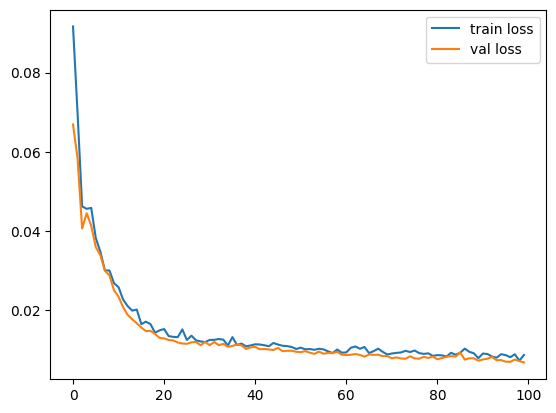

Epoch = 99, Train loss = 0.0087, Val loss = 0.0068: 100%|██████████| 100/100 [00:02<00:00, 40.93it/s]


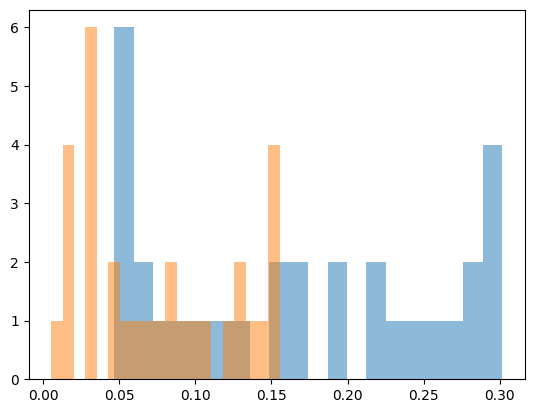

Successful fine-tuning
Switch model at step 253
Drift detected at iteration 803


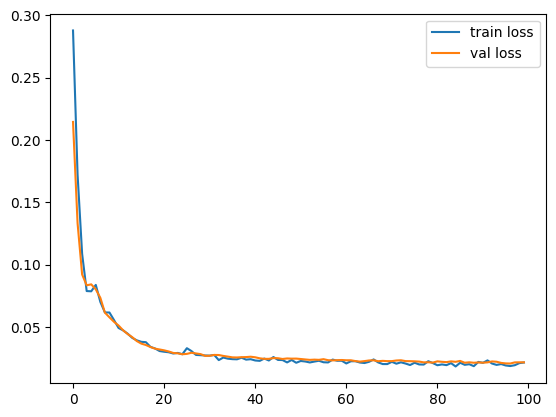

Epoch = 99, Train loss = 0.0216, Val loss = 0.0217: 100%|██████████| 100/100 [00:02<00:00, 42.10it/s]


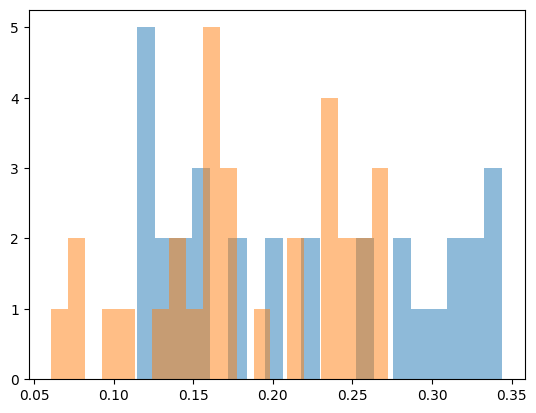

Successful fine-tuning
Switch model at step 953
Drift detected at iteration 982


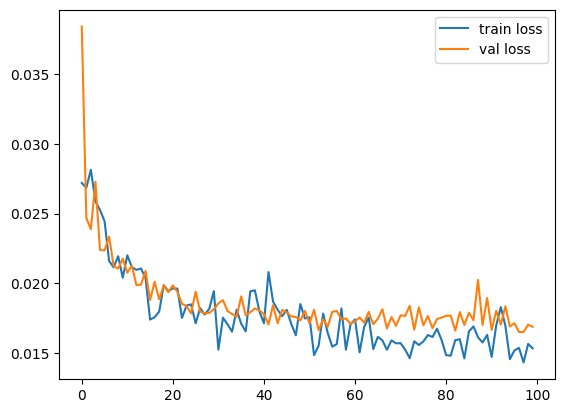

Epoch = 99, Train loss = 0.0153, Val loss = 0.0169: 100%|██████████| 100/100 [00:02<00:00, 41.49it/s]


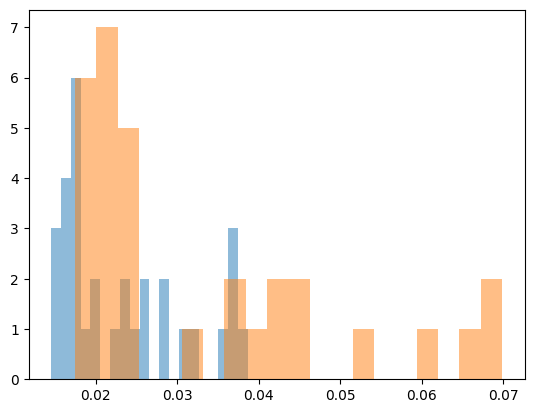

Unsuccessful fine-tuning
Drift detected at iteration 1159


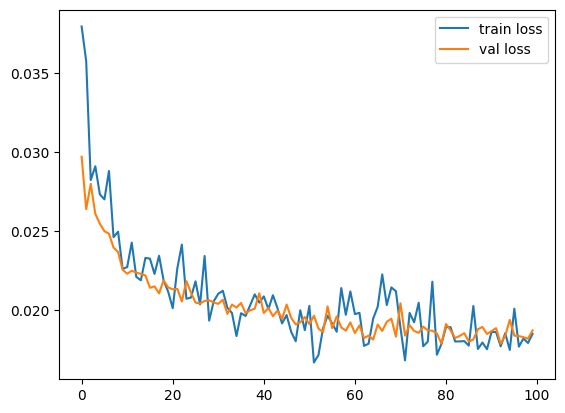

Epoch = 99, Train loss = 0.0185, Val loss = 0.0187: 100%|██████████| 100/100 [00:02<00:00, 39.93it/s]


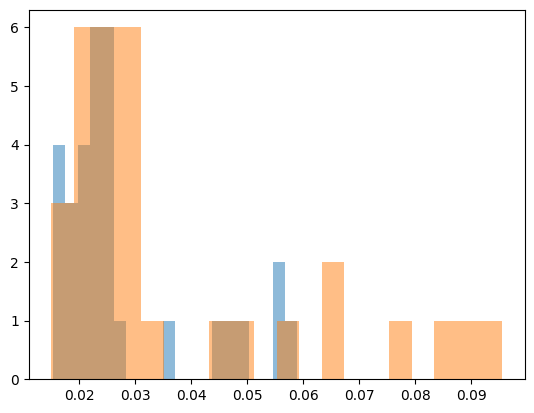

Unsuccessful fine-tuning
Drift detected at iteration 1337


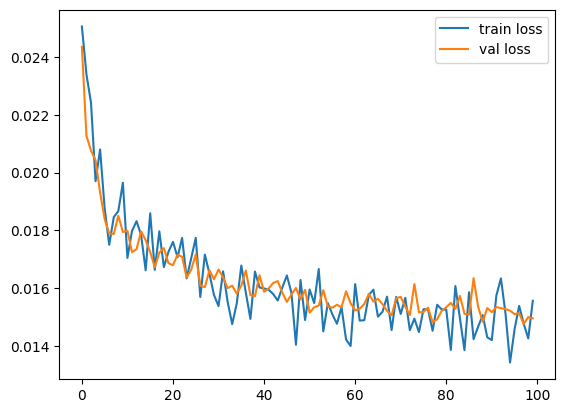

Epoch = 99, Train loss = 0.0156, Val loss = 0.0150: 100%|██████████| 100/100 [00:02<00:00, 41.75it/s]


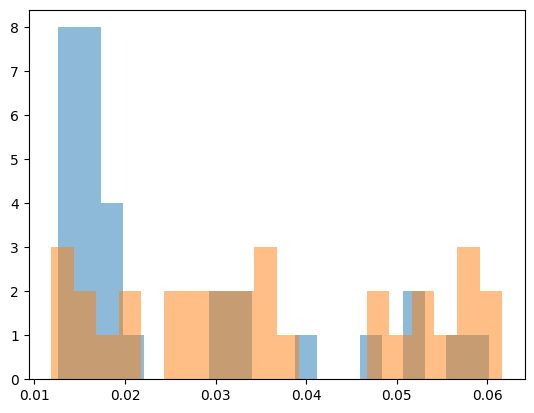

Unsuccessful fine-tuning


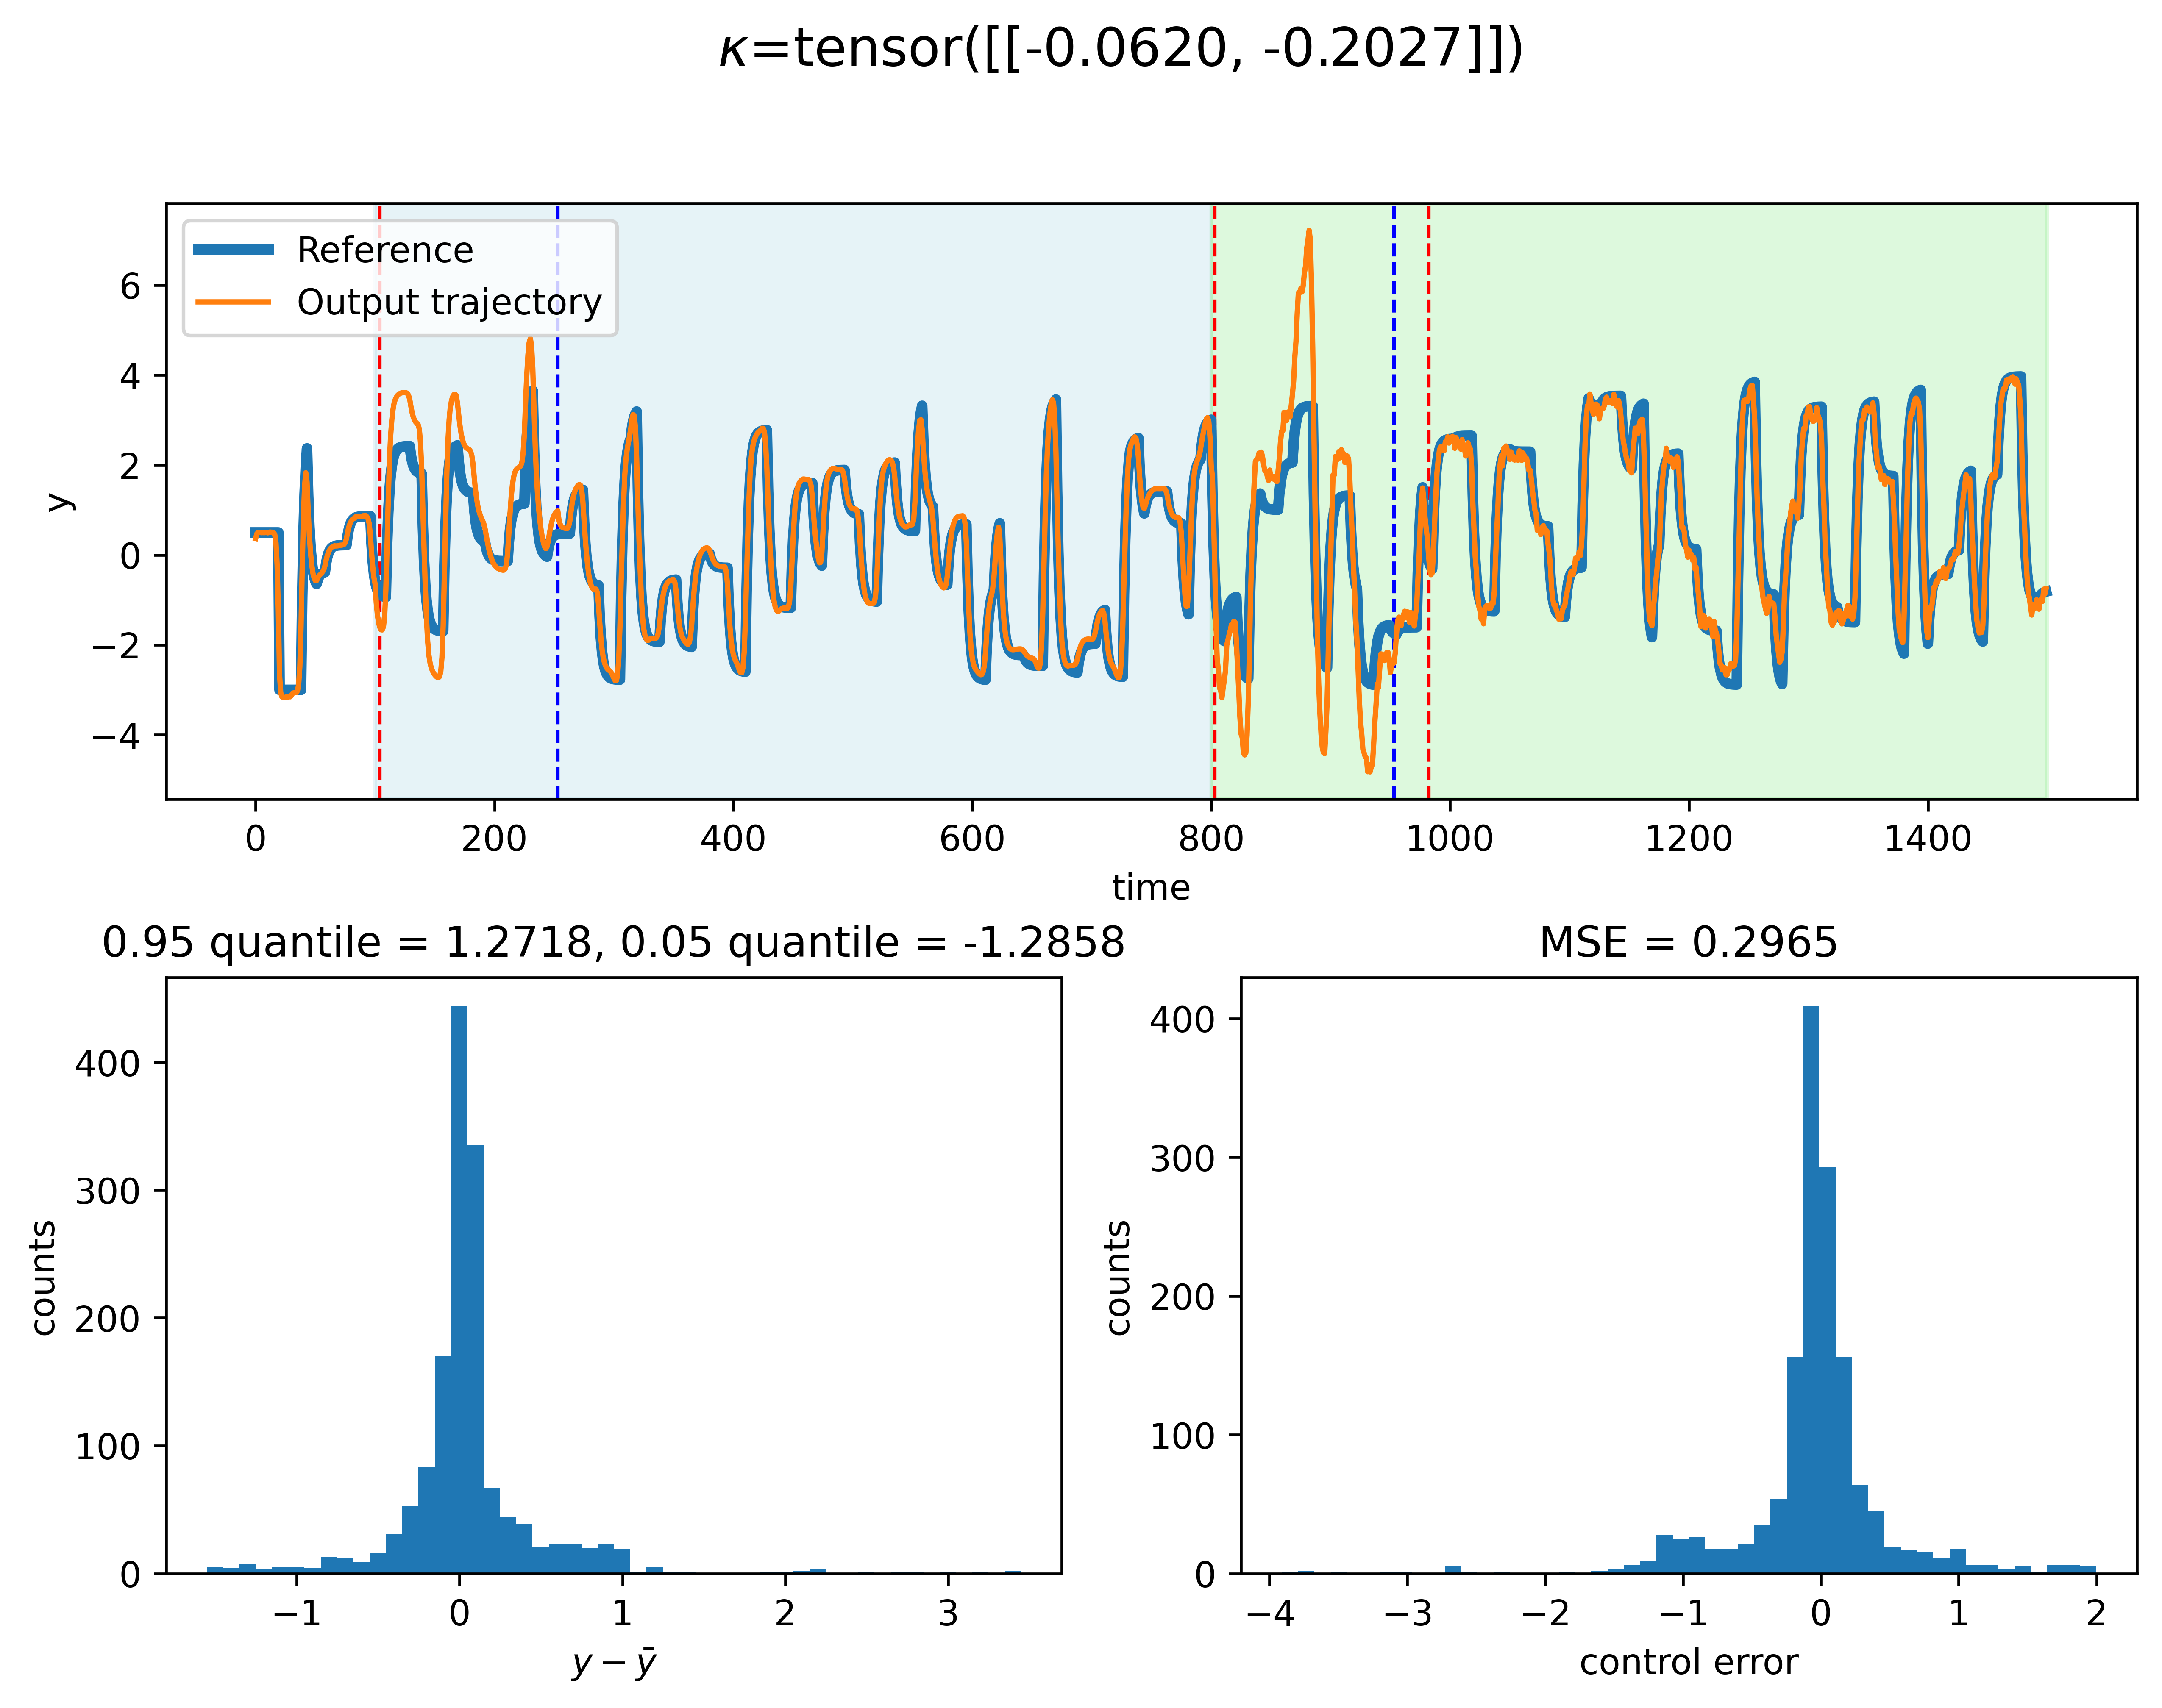

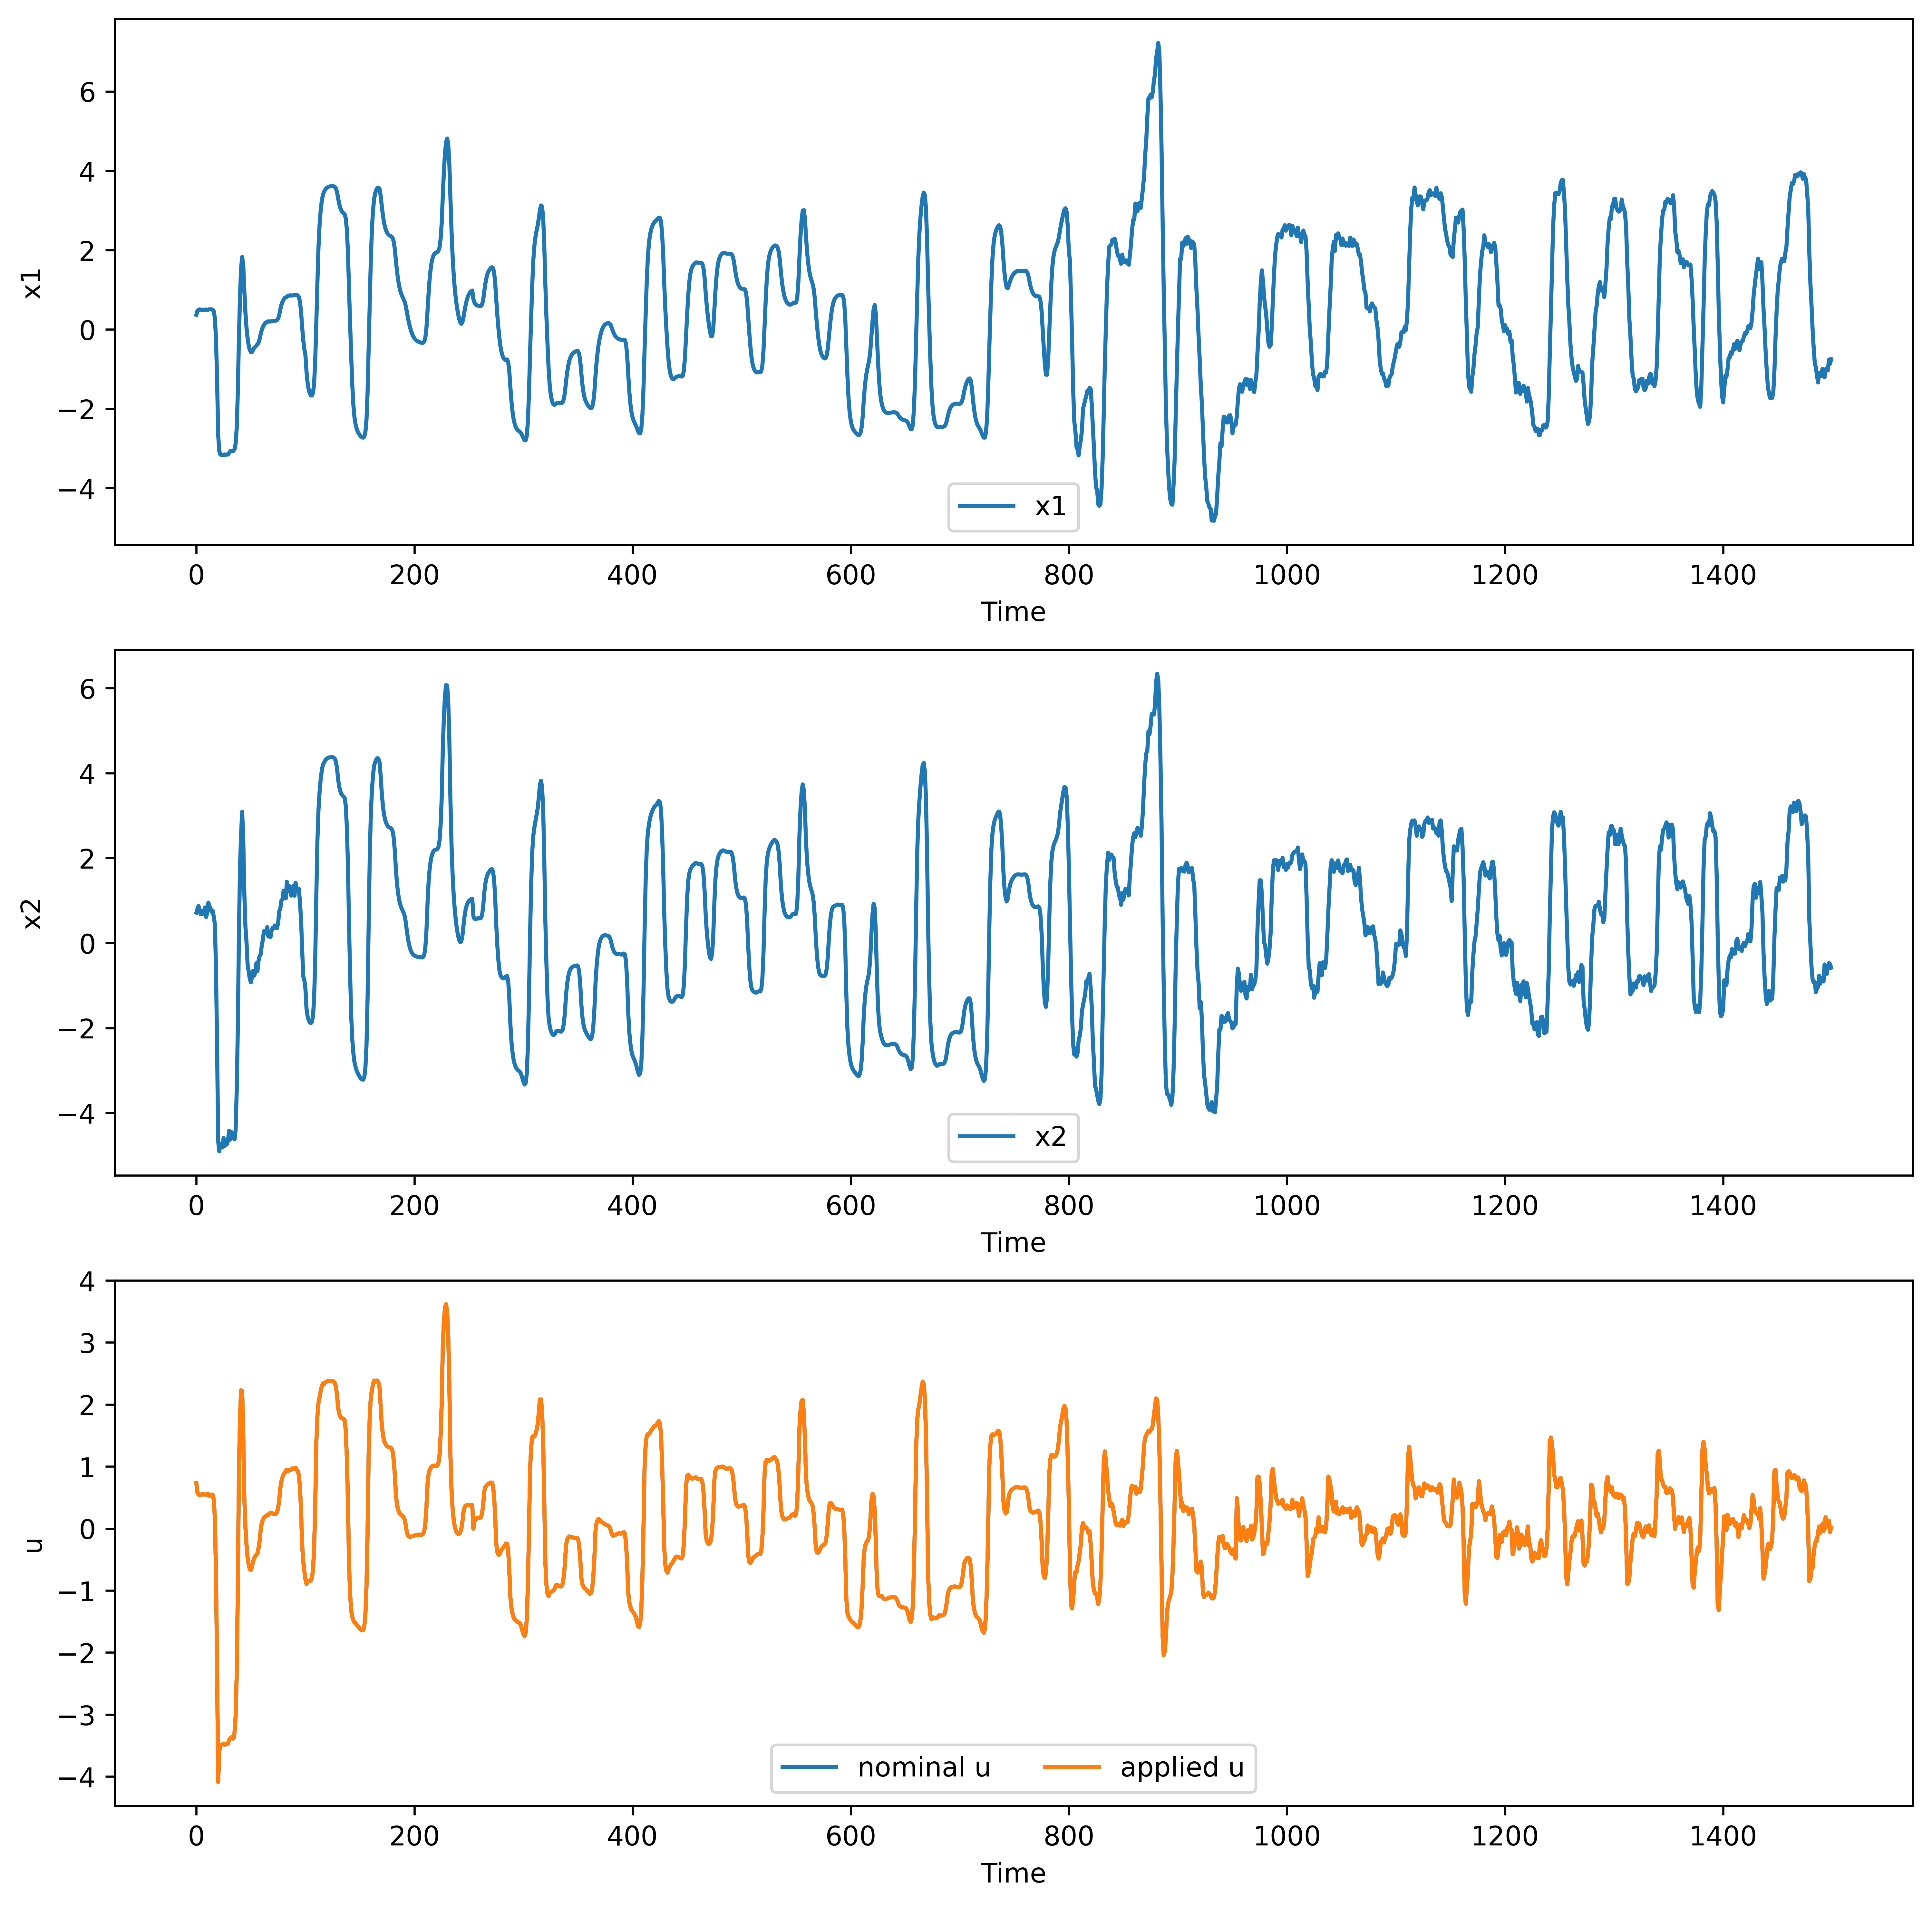

In [22]:

# Run MPC

n_steps = 1500

run_drift_detection = True
RobustMPC.noise_injection_time = [100,800]

for i in tqdm(range(n_steps)):
    SP_hat = Ref_traj[i:i+P]
    RobustMPC.run_one_step(SP_hat=SP_hat, RMPC=False)
    if i == 100: 
        RobustMPC.sys_model.A = torch.tensor([[0.5, 0.05], [0.2, 0.2]], dtype=torch.float32)
        # RobustMPC.sys_model.w = torch.tensor([[0],[0]], dtype=torch.float32)
        # RobustMPC.sys_model.A = torch.tensor([[0.6, 0.25], [0.2, 0.4]], dtype=torch.float32)
        RobustMPC.sys_model.system_ID = 1
        RobustMPC.sys_model.w = torch.tensor([[0],[0]], dtype=torch.float32)
    
    if i == 800: 
         RobustMPC.sys_model.A = torch.tensor([[0.6, 0.25], [0.2, 0.4]], dtype=torch.float32)
         RobustMPC.sys_model.system_ID = 1
         RobustMPC.sys_model.w = torch.tensor([[0.1],[0.1]], dtype=torch.float32)
    
    if run_drift_detection:    
        run_drift_detection = RobustMPC.drift_detection(current_iter=i, fine_tune=True)
        if RobustMPC.drift_occur_flag == 1:
            RobustMPC.drift_detected_time.append(i)
        
    else:
        run_drift_detection, success_fine_tune = RobustMPC.LoRA_validation()
        if success_fine_tune:
            print(f"Switch model at step {i}")
            RobustMPC.model_switch_time.append(i)

# Plots    
RobustMPC.Plot_standard_w_drift(Ref_traj,n_steps,plot_traj_steps=n_steps,show_constraints=False)
RobustMPC.Plot_input_output(show_constraint=False)


In [23]:
RobustMPC.drift_detected_time

[104, 803, 982]

In [24]:
RobustMPC.model_switch_time

[253, 953]

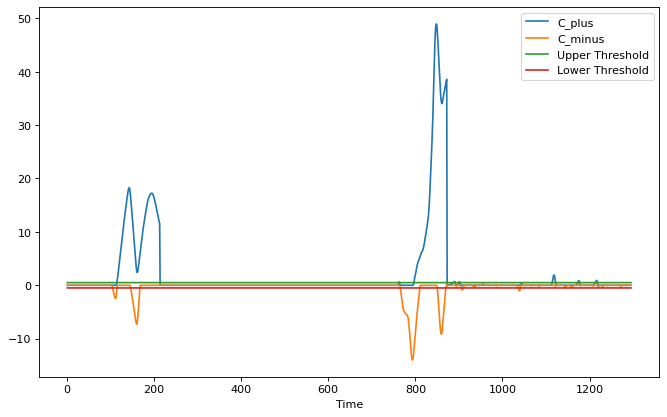

In [25]:
RobustMPC.DriftDetector.plot_CUSUM()

In [26]:
# for buffer_ID in range(100):
#     plt.figure()
#     plt.plot(np.linspace(0,9,10), RobustMPC.buffer['u_past'][buffer_ID,0,:], label='u_past')
#     plt.plot(np.linspace(0,9,10), RobustMPC.buffer['x_past'][buffer_ID,0,:], label='x_past')

#     plt.plot(np.linspace(10,19,10),RobustMPC.buffer['u_future'][buffer_ID,0,:], label='u_future')
#     plt.plot(np.linspace(10,19,10),RobustMPC.buffer['x_future'][buffer_ID,0,:], label='x_future')
#     plt.legend()
#     plt.ylim(-1,1)

0.43054044

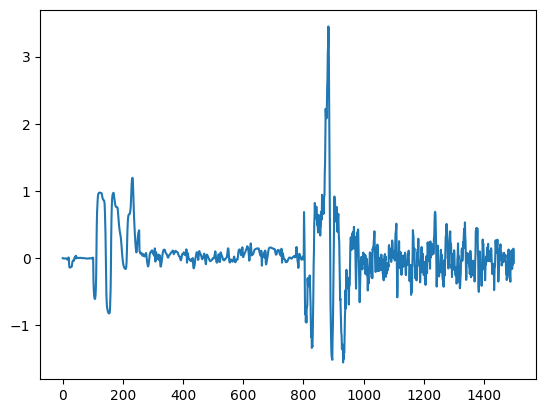

In [27]:
plt.plot(RobustMPC.e_save[0,:])
np.std(RobustMPC.e_save[0,:].detach().numpy())

In [28]:
RobustMPC.noise_injection_time

[100, 800]

In [29]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML
# import matplotlib as mpl
# mpl.rcParams['savefig.facecolor'] = 'white'
# mpl.rcParams['savefig.edgecolor'] = 'white'

# # Assuming these variables are defined somewhere in your code:
# # MPC_iters = n_steps
# # P, Ref_traj, RobustMPC

# MPC_iters = n_steps

# # Set up the figure with two subplots sharing the same x-axis
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), dpi=100, sharex=True,facecolor='white')

# # Adjust subplot parameters to remove the gap between subplots
# plt.subplots_adjust(hspace=0.05)

# breaks = RobustMPC.noise_injection_time
# colors = ['lightblue', 'lightgreen']

# # Configure ax1
# if len(breaks) == 2:
#     # Special case: only two breakpoints
#     a, b = breaks
#     ax1.axvspan(a, b, color=colors[0], alpha=0.3)
#     ax1.axvspan(b, n_steps, color=colors[1], alpha=0.3)
# else:
#     # General case: multiple breakpoints
#     for i in range(len(breaks) - 1):
#         ax1.axvspan(breaks[i], breaks[i+1], color=colors[i % len(colors)], alpha=0.3)
#     ax1.axvspan(breaks[-1], n_steps, color=colors[len(breaks) % len(colors)], alpha=0.3)
    
# ax1.set_ylabel("$x_1$", fontsize=16)
# ax1.set_xlim(-1, MPC_iters + P)
# ax1.set_ylim(-3, 5)
# # ax1.plot(np.ones((n_steps, 1)) * 2.5, '--', color='orange')
# # ax1.plot(np.ones((n_steps, 1)) * -2, '--', color='orange')
# ax1.plot(Ref_traj[:n_steps], '--', linewidth=1, color='black', label="Reference")
# ax1.set_facecolor('white')
# #ax1.set_title(f"Multi-step robust MPC in noisy environment")

# # Configure ax2
# if len(breaks) == 2:
#     # Special case: only two breakpoints
#     a, b = breaks
#     ax2.axvspan(a, b, color=colors[0], alpha=0.3)    
#     ax2.axvspan(b, n_steps, color=colors[1], alpha=0.3)
# else:
#     # General case: multiple breakpoints
#     for i in range(len(breaks) - 1):
#         ax2.axvspan(breaks[i], breaks[i+1], color=colors[i % len(colors)], alpha=0.3)
#     ax2.axvspan(breaks[-1], n_steps, color=colors[len(breaks) % len(colors)], alpha=0.3)
    
    
# ax2.set_ylabel("$x_2$", fontsize=16)
# ax2.set_xlim(-1, MPC_iters + P)
# ax2.set_ylim(-5, 5)
# ax2.set_facecolor('white')
# # ax2.plot(np.ones((n_steps, 1)) * 3.5, '--', color='orange')
# # ax2.plot(np.ones((n_steps, 1)) * -3.5, '--', color='orange',label="Constraints")
# ax2.set_xlabel("Time", fontsize=14)

# # Plot breaks using drift detection
# breaks = RobustMPC.drift_detected_time
# for bp in breaks:
#     ax1.axvline(bp, color='r', linestyle='--', linewidth=1)
#     ax2.axvline(bp, color='r', linestyle='--', linewidth=1)
    
# # Plot breaks using model switch
# breaks = RobustMPC.model_switch_time
# for bp in breaks:
#     ax1.axvline(bp, color='b', linestyle='--', linewidth=1)
#     ax2.axvline(bp, color='b', linestyle='--', linewidth=1)



# # Define plots for both subplots
# real_output_plot1, = ax1.plot([], [], label="Output", color='blue', linewidth=2)
# point_current1, = ax1.plot([], [], ".", markersize=20, label="Current")
# line_pred1, = ax1.plot([], [], "-", linewidth=1.5, color="red", label="Prediction")
# line_true1, = ax1.plot([], [], "-", linewidth=1.5, color="green", label="True")
# tube_x1_1 = ax1.fill_between(np.linspace(0, P + 1, P + 1), np.zeros((P + 1)) * 1, np.zeros((P + 1)) * 1, alpha=0.3, label="Tube")

# real_output_plot2, = ax2.plot([], [], label="Output", color='blue', linewidth=2)
# point_current2, = ax2.plot([], [], ".", markersize=20, label="Current")
# line_pred2, = ax2.plot([], [], "-", linewidth=1.5, color="red", label="Prediction")
# line_true2, = ax2.plot([], [], "-", linewidth=1.5, color="green", label="True")
# #tube_x1_2 = ax2.fill_between(np.linspace(0, P + 1, P + 1), np.zeros((P + 1)) * 1, np.zeros((P + 1)) * 1, alpha=0.3, label="Distrubance quantile")
# tube_x1_nominal = ax2.fill_between(np.linspace(0, P + 1, P + 1), np.zeros((P + 1)) * 1, np.zeros((P + 1)) * 1, alpha=0.6, color='pink', label="Quantile")
# ax2.plot([], '--', linewidth=1, color='black', label="Reference")
# ax2.legend(loc='lower center',bbox_to_anchor=(0.5, -0.5), ncol=3)

# plt.tight_layout()
# # Global variables to store the collections
# tube_fill1 = None
# nominal_tube_fill1 = None
# tube_fill2 = None
# nominal_tube_fill2 = None

# # Function to update the plots in each iteration
# def update(iter):
#     global tube_fill1, nominal_tube_fill1, tube_fill2, nominal_tube_fill2
    
#     real_output_plot1.set_data(np.linspace(0, len(RobustMPC.real_output[0, :iter + 1]) - 1, len(RobustMPC.real_output[0, :iter + 1])), RobustMPC.real_output[0, :iter + 1])
#     point_current1.set_data(iter, RobustMPC.real_output[0, iter])
#     pred1 = np.concatenate((RobustMPC.real_output[0, iter].reshape(-1, 1), RobustMPC.x_hat_horizon_save[iter, :].reshape(-1, 1)), axis=0).flatten()
#     line_pred1.set_data(np.linspace(iter, iter + P + 1, P + 1), pred1)
#     line_true1.set_data(np.linspace(iter, iter + P + 1, P + 1), np.concatenate((RobustMPC.real_output[0, iter].reshape(-1, 1), RobustMPC.true_pred_output_x1_save[iter, :].reshape(-1, 1)), axis=0))
    
#     tube_upper1 = np.concatenate((np.zeros((1, 1)), RobustMPC.error_past_x1_upper[iter].reshape(-1, 1)), axis=0).flatten()
#     tube_lower1 = np.concatenate((np.zeros((1, 1)), RobustMPC.error_past_x1_lower[iter].reshape(-1, 1)), axis=0).flatten()
#     nominal_tube_upper1 = np.concatenate((np.zeros((1, 1)), RobustMPC.nominal_x1_upper_quantile[iter].reshape(-1, 1)), axis=0).flatten()
#     nominal_tube_lower1 = np.concatenate((np.zeros((1, 1)), RobustMPC.nominal_x1_lower_quantile[iter].reshape(-1, 1)), axis=0).flatten()

#     # Remove previous fill_between collections if they exist
#     if tube_fill1:
#         tube_fill1.remove()
#     if nominal_tube_fill1:
#         nominal_tube_fill1.remove()
    
#     # tube_fill1 = ax1.fill_between(np.linspace(iter, iter + P + 1, P + 1), tube_upper1 + pred1, tube_lower1 + pred1, alpha=0.3, color='blue')
#     nominal_tube_fill1 = ax1.fill_between(np.linspace(iter, iter + P + 1, P + 1), nominal_tube_upper1 + pred1, nominal_tube_lower1 + pred1, alpha=0.6, color='pink')

#     real_output_plot2.set_data(np.linspace(0, len(RobustMPC.real_output[1, :iter + 1]) - 1, len(RobustMPC.real_output[1, :iter + 1])), RobustMPC.real_output[1, :iter + 1])
#     point_current2.set_data(iter, RobustMPC.real_output[1, iter])
#     pred2 = np.concatenate((RobustMPC.real_output[1, iter].reshape(-1, 1), RobustMPC.x2_hat_horizon_save[iter, :].reshape(-1, 1)), axis=0).flatten()
#     line_pred2.set_data(np.linspace(iter, iter + P + 1, P + 1), pred2)
#     line_true2.set_data(np.linspace(iter, iter + P + 1, P + 1), np.concatenate((RobustMPC.real_output[1, iter].reshape(-1, 1), RobustMPC.true_pred_output_x2_save[iter, :].reshape(-1, 1)), axis=0))
    
#     tube_upper2 = np.concatenate((np.zeros((1, 1)), RobustMPC.error_past_x2_upper[iter].reshape(-1, 1)), axis=0).flatten()
#     tube_lower2 = np.concatenate((np.zeros((1, 1)), RobustMPC.error_past_x2_lower[iter].reshape(-1, 1)), axis=0).flatten()
#     nominal_tube_upper2 = np.concatenate((np.zeros((1, 1)), RobustMPC.nominal_x2_upper_quantile[iter].reshape(-1, 1)), axis=0).flatten()
#     nominal_tube_lower2 = np.concatenate((np.zeros((1, 1)), RobustMPC.nominal_x2_lower_quantile[iter].reshape(-1, 1)), axis=0).flatten()
    
#     # Remove previous fill_between collections if they exist
#     if tube_fill2:
#         tube_fill2.remove()
#     if nominal_tube_fill2:
#         nominal_tube_fill2.remove()
    
    
#     #tube_fill2 = ax2.fill_between(np.linspace(iter, iter + P + 1, P + 1), tube_upper2 + pred2, tube_lower2 + pred2, alpha=0.3, color='blue')
#     nominal_tube_fill2 = ax2.fill_between(np.linspace(iter, iter + P + 1, P + 1), nominal_tube_upper2 + pred2, nominal_tube_lower2 + pred2, alpha=0.6, color='pink')
    
#     return [real_output_plot1, point_current1, line_pred1, line_true1, real_output_plot2, point_current2, line_pred2, line_true2]

# # Create animation
# MPC_iters = 10
# animation = FuncAnimation(fig, update, frames=MPC_iters, blit=True)

# # Show the animation
# HTML(animation.to_jshtml())
# plt.rcParams["animation.html"] = "jshtml"
# animation.save('robust_MPC_in_noisy_environment.gif', writer='pillow', fps=30)
# animation


KeyboardInterrupt: 

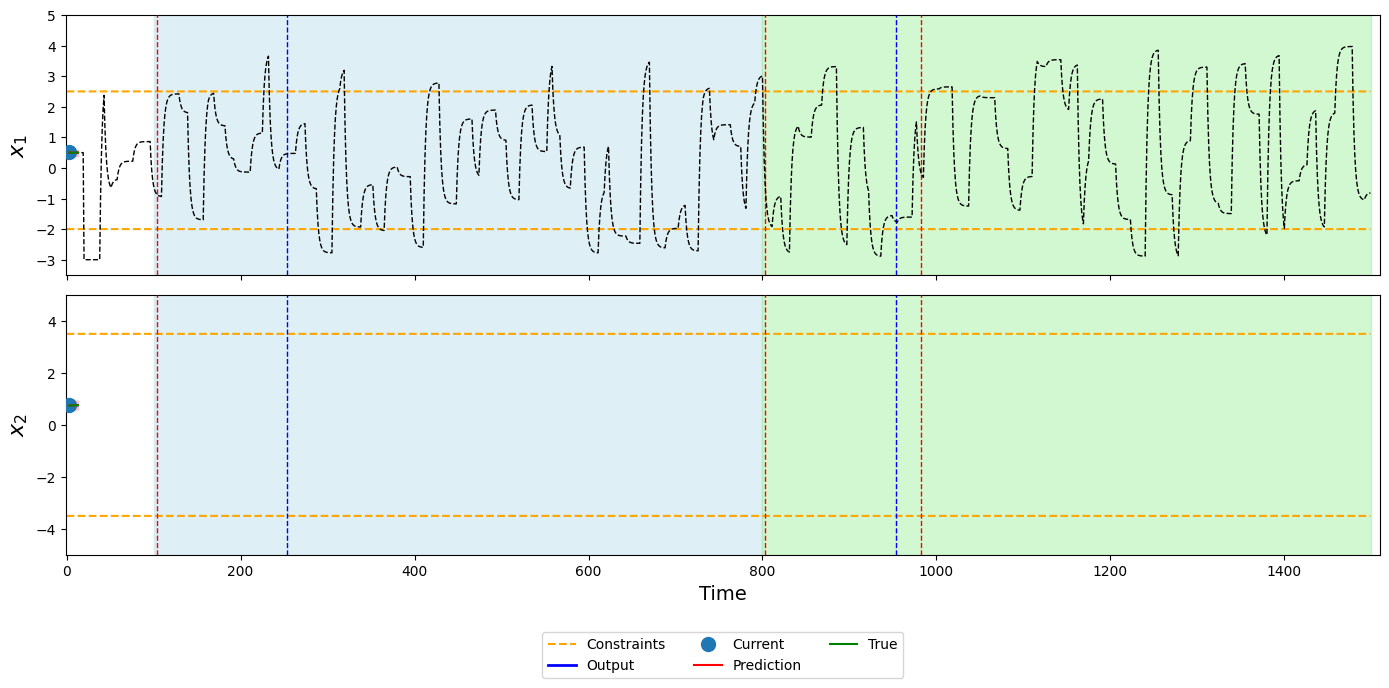

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib as mpl

# Global white background setup
mpl.rcParams['savefig.facecolor'] = 'white'
mpl.rcParams['savefig.edgecolor'] = 'white'

# Set up figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), dpi=100, sharex=True, facecolor='white')
plt.subplots_adjust(hspace=0.05)

MPC_iters = n_steps  # Assuming this is defined

# Background patches (light colors, no alpha)
breaks = RobustMPC.noise_injection_time
colors = ['lightblue', 'lightgreen']

if len(breaks) == 2:
    a, b = breaks
    ax1.axvspan(a, b, color=colors[0], zorder=0, alpha = 0.4)
    ax1.axvspan(b, n_steps, color=colors[1], zorder=0, alpha = 0.4)
    ax2.axvspan(a, b, color=colors[0], zorder=0, alpha = 0.4)
    ax2.axvspan(b, n_steps, color=colors[1], zorder=0, alpha = 0.4)
else:
    for i in range(len(breaks) - 1):
        ax1.axvspan(breaks[i], breaks[i + 1], color=colors[i % len(colors)], zorder=0, alpha = 0.4)
        ax2.axvspan(breaks[i], breaks[i + 1], color=colors[i % len(colors)], zorder=0, alpha = 0.4)
    ax1.axvspan(breaks[-1], n_steps, color=colors[len(breaks) % len(colors)], zorder=0, alpha = 0.4)
    ax2.axvspan(breaks[-1], n_steps, color=colors[len(breaks) % len(colors)], zorder=0, alpha = 0.4)

# Axis settings
for ax in [ax1, ax2]:
    ax.set_facecolor('white')

ax1.set_ylabel("$x_1$", fontsize=16)
ax1.set_xlim(-1, MPC_iters + P)
ax1.set_ylim(-3.5, 5)
ax1.plot(Ref_traj[:n_steps], '--', linewidth=1, color='black', label="Reference", zorder=5)
ax1.plot(np.ones((n_steps, 1)) * 2.5, '--', color='orange')
ax1.plot(np.ones((n_steps, 1)) * -2, '--', color='orange')

ax2.set_ylabel("$x_2$", fontsize=16)
ax2.set_xlim(-1, MPC_iters + P)
ax2.set_ylim(-5, 5)
ax2.set_xlabel("Time", fontsize=14)
ax2.plot(np.ones((n_steps, 1)) * 3.5, '--', color='orange')
ax2.plot(np.ones((n_steps, 1)) * -3.5, '--', color='orange',label="Constraints")

# Breaks: drift detection
for bp in RobustMPC.drift_detected_time:
    ax1.axvline(bp, color='r', linestyle='--', linewidth=1, zorder=3)
    ax2.axvline(bp, color='r', linestyle='--', linewidth=1, zorder=3)

# Breaks: model switch
for bp in RobustMPC.model_switch_time:
    ax1.axvline(bp, color='b', linestyle='--', linewidth=1, zorder=3)
    ax2.axvline(bp, color='b', linestyle='--', linewidth=1, zorder=3)

# Initialize plots
real_output_plot1, = ax1.plot([], [], label="Output", color='blue', linewidth=2, zorder=5)
point_current1, = ax1.plot([], [], ".", markersize=20, label="Current", zorder=6)
line_pred1, = ax1.plot([], [], "-", linewidth=1.5, color="red", label="Prediction", zorder=6)
line_true1, = ax1.plot([], [], "-", linewidth=1.5, color="green", label="True", zorder=6)

real_output_plot2, = ax2.plot([], [], label="Output", color='blue', linewidth=2, zorder=5)
point_current2, = ax2.plot([], [], ".", markersize=20, label="Current", zorder=6)
line_pred2, = ax2.plot([], [], "-", linewidth=1.5, color="red", label="Prediction", zorder=6)
line_true2, = ax2.plot([], [], "-", linewidth=1.5, color="green", label="True", zorder=6)

ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3)

plt.tight_layout()

# Tube collections
tube_fill1 = None
nominal_tube_fill1 = None
tube_fill2 = None
nominal_tube_fill2 = None

def update(iter):
    global tube_fill1, nominal_tube_fill1, tube_fill2, nominal_tube_fill2

    # Ensure white background every frame
    ax1.set_facecolor('white')
    ax2.set_facecolor('white')
    fig.patch.set_facecolor('white')

    # Subplot 1
    real_output_plot1.set_data(np.arange(iter + 1), RobustMPC.real_output[0, :iter + 1])
    point_current1.set_data(iter, RobustMPC.real_output[0, iter])

    pred1 = np.concatenate(([RobustMPC.real_output[0, iter]], RobustMPC.x_hat_horizon_save[iter, :]))
    line_pred1.set_data(np.arange(iter, iter + P + 1), pred1)
    line_true1.set_data(np.arange(iter, iter + P + 1), np.concatenate(([RobustMPC.real_output[0, iter]], RobustMPC.true_pred_output_x1_save[iter, :])))

    tube_upper1 = np.concatenate(([0], RobustMPC.error_past_x1_upper[iter]))
    tube_lower1 = np.concatenate(([0], RobustMPC.error_past_x1_lower[iter]))
    nominal_upper1 = np.concatenate(([0], RobustMPC.nominal_x1_upper_quantile[iter]))
    nominal_lower1 = np.concatenate(([0], RobustMPC.nominal_x1_lower_quantile[iter]))

    if tube_fill1:
        tube_fill1.remove()
    if nominal_tube_fill1:
        nominal_tube_fill1.remove()

    # tube_fill1 = ax1.fill_between(np.arange(iter, iter + P + 1),
    #                               tube_upper1 + pred1, tube_lower1 + pred1,
    #                               color='lightblue', alpha=1.0, zorder=1)
    nominal_tube_fill1 = ax1.fill_between(np.arange(iter, iter + P + 1),
                                          nominal_upper1 + pred1, nominal_lower1 + pred1,
                                          color='pink', alpha=1.0, zorder=2)

    # Subplot 2
    real_output_plot2.set_data(np.arange(iter + 1), RobustMPC.real_output[1, :iter + 1])
    point_current2.set_data(iter, RobustMPC.real_output[1, iter])

    pred2 = np.concatenate(([RobustMPC.real_output[1, iter]], RobustMPC.x2_hat_horizon_save[iter, :]))
    line_pred2.set_data(np.arange(iter, iter + P + 1), pred2)
    line_true2.set_data(np.arange(iter, iter + P + 1), np.concatenate(([RobustMPC.real_output[1, iter]], RobustMPC.true_pred_output_x2_save[iter, :])))

    tube_upper2 = np.concatenate(([0], RobustMPC.error_past_x2_upper[iter]))
    tube_lower2 = np.concatenate(([0], RobustMPC.error_past_x2_lower[iter]))
    nominal_upper2 = np.concatenate(([0], RobustMPC.nominal_x2_upper_quantile[iter]))
    nominal_lower2 = np.concatenate(([0], RobustMPC.nominal_x2_lower_quantile[iter]))

    if tube_fill2:
        tube_fill2.remove()
    if nominal_tube_fill2:
        nominal_tube_fill2.remove()

    # tube_fill2 = ax2.fill_between(np.arange(iter, iter + P + 1),
    #                               tube_upper2 + pred2, tube_lower2 + pred2,
    #                               color='lightblue', alpha=1.0, zorder=1)
    nominal_tube_fill2 = ax2.fill_between(np.arange(iter, iter + P + 1),
                                          nominal_upper2 + pred2, nominal_lower2 + pred2,
                                          color='pink', alpha=1.0, zorder=2)

    return [real_output_plot1, point_current1, line_pred1, line_true1,
            real_output_plot2, point_current2, line_pred2, line_true2]

# Create animation
animation = FuncAnimation(fig, update, frames=MPC_iters, blit=True)

# Show in notebook
HTML(animation.to_jshtml())
plt.rcParams["animation.html"] = "jshtml"

# Save GIF (use pillow)
animation.save('robust_MPC_in_noisy_environment.gif', writer='pillow', fps=30)
